
# Práctica de Detección de Rostros Reales y Falsos con Redes Neuronales Convolucionales (CNN) en PyTorch

**Objetivo:** Desarrollar un modelo de clasificación basado en una CNN para distinguir entre imágenes de rostros reales y falsificados por expertos.

**Introducción:** 
En la era digital, el uso de imágenes falsificadas ha ido en aumento, especialmente en las redes sociales. La identificación de estas imágenes es crucial para garantizar la autenticidad de la información. Aunque existen modelos generativos como las GANs que pueden producir rostros falsos, los falsificadores humanos utilizan técnicas distintas que a menudo desafían a los modelos automáticos.

**Datos:**
Se proporciona un conjunto de datos que contiene imágenes de rostros, tanto reales como modificadas por expertos. Las imágenes falsificadas se dividen en tres categorías según su dificultad de detección: fácil, medio y difícil. [Enlace al conjunto de datos](https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection).

**Instrucciones:**

1. **Preprocesamiento de Datos:**
   - Descarga y descomprime el conjunto de datos.
   - Divide los datos en conjuntos de entrenamiento y prueba.
   - Normaliza las imágenes y conviértelas en tensores.

2. **Construcción del Modelo:**
   - Diseña una CNN para clasificar imágenes de rostros reales y falsificados.
   - Añade capas totalmente conectadas al final para la clasificación.

3. **Entrenamiento:**
   - Define una función de pérdida y un optimizador.
   - Entrena el modelo usando el conjunto de entrenamiento.
   - Evalúa el rendimiento del modelo en el conjunto de prueba tras cada época.

4. **Evaluación:**
   - Utiliza el Accuracy para evaluar el rendimiento del modelo.
   - Visualiza algunas predicciones del modelo para entender sus aciertos y errores.

5. **Conclusión:**
   - Discute los resultados obtenidos.
   - Sugerencias para mejorar el rendimiento del modelo.

6. **Extras:**
   - Explora diferentes arquitecturas de CNN.
   - Usas otras métricas de evaluación (F1, Precision, Recall, etc.)
   - Utiliza técnicas de aumento de datos para mejorar el rendimiento del modelo.
   - Buscar otros conjuntos de datos extras para entrenar el modelo.
   - Utiliza técnicas de regularización para evitar el sobreajuste del modelo.
   - Transfer Learning: Utiliza un modelo pre-entrenado para mejorar el rendimiento del modelo.
   - Usar otras liberias de Deep Learning como pytorch-lightning o wandb
   - Usar liberias de optimización como optuna, etc.
   - ...

7. **Competición:**
   - Un punto extra se otorgará a los 3 mejores modelos de la clase.
   - Gana el modelo que obtenga el Accuracy más alto en un conjunto de datos de prueba oculto, que ya os pasaré
   - No uses ese conjunto de datos para entrenar tu modelo, solo para evaluarlo al final !!

**Entregables:**
- Código fuente en Python del modelo.
- Un informe detallando el diseño del modelo, resultados, conclusiones y recomendaciones.
- **Lo quiero todo subido a un repositorio en GitHub.**

# Preprocesamiento de Datos:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#DATASET = os.path.join('datasets', 'real_and_fake_face') # esto puede cambiar dependiendo de donde se ejecute el notebook
DATASET = 'real_and_fake_face'
INITIAL_SIZE_OF_IMAGES = (128, 128)

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor()
])

full_train_dataset = datasets.ImageFolder(root=DATASET,  transform=data_transforms)
#print(full_train_dataset[0]) image tensor
print(full_train_dataset[0][0].shape) #torch.Size([3, 128, 128])
print(len(full_train_dataset))

train_size = int(0.8 * len(full_train_dataset)) # 90% para entrenamiento
valid_size = int(0.1 * len(full_train_dataset)) # 10% para validación
test_size = len(full_train_dataset) - train_size - valid_size
train_dataset, valid_dataset,test_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, valid_size, test_size])
print(train_dataset[0][0].shape)
print(train_dataset[0][1])   #label

num_samples = len(train_dataset)
labels = np.empty(num_samples, dtype=int)

#for i in range(num_samples):
#    _, label = train_dataset[i]  # Get the data sample and its label
#    labels[i] = label
#print(labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#print(train_loader[0])
print(train_size)
print(valid_size)
print(test_size)

torch.Size([3, 128, 128])
2041
torch.Size([3, 128, 128])
0
1632
204
205


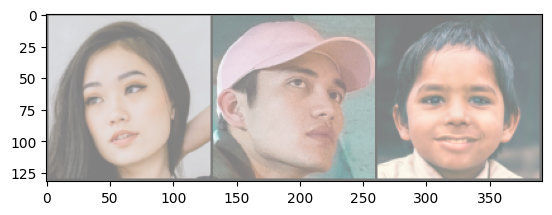

labels:  tensor([1, 1, 0])


In [4]:
for batch in train_loader:
    images, labels = batch

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mostramos las imagenes
imshow(vutils.make_grid(images[1:4], normalize=True))
print("labels: ", labels[1:4])



In [5]:
print(images[0].shape[2])
image_height,image_width = images[0].shape[1] , images[0].shape[2]


128


# Construcción del Modelo:

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cpu para entrenar


In [7]:
import torch.nn.functional as F
image_height = 128
image_width = 128

class face_CNN(nn.Module):
    def __init__(self, learning_rate=0.001, dropout_rate=0.5, filters=32, fc1_units=128):
        super(face_CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, filters, 3, padding=1)
        self.conv2 = nn.Conv2d(filters, filters * 2, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the dimensions based on your image size (128x128)
        conv_output_size = filters * 2 * (image_height // 4) * (image_width // 4)
        self.fc1 = nn.Linear(conv_output_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, 2) 

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


        



## Entrenamiento

In [8]:
# Crear una instancia de la red
model = face_CNN().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

face_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [9]:
#import torch
#import torch.nn as nn
#import torch.optim as optim
#import torchvision
#import torchvision.transforms as transforms

# 3. Bucle de entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad() # Reinicia los gradientes porque backward acumula los gradientes en cada iteración
        loss.backward() # Calcula los gradientes
        optimizer.step() # Actualiza los parámetros
        
        if (i+1) % 51 == 0:
            # Epoch: es el número de veces que el modelo ha visto el conjunto de datos completo
            # Step: es el número de veces que el modelo ha visto un batch
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Entrenamiento finalizado!")

# 4. Evaluación del modelo
model.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las {len(full_train_dataset)} imágenes de prueba: {100 * correct / total}%')

Epoch [1/10], Step [51/51], Loss: 0.6928
Epoch [2/10], Step [51/51], Loss: 0.6949
Epoch [3/10], Step [51/51], Loss: 0.7024
Epoch [4/10], Step [51/51], Loss: 0.6354
Epoch [5/10], Step [51/51], Loss: 0.6027
Epoch [6/10], Step [51/51], Loss: 0.5423
Epoch [7/10], Step [51/51], Loss: 0.6515
Epoch [8/10], Step [51/51], Loss: 0.4756
Epoch [9/10], Step [51/51], Loss: 0.4655
Epoch [10/10], Step [51/51], Loss: 0.4218
Entrenamiento finalizado!
Precisión del modelo en las 2041 imágenes de prueba: 62.926829268292686%


## Evaluación

In [10]:
import torch
from sklearn.metrics import classification_report


def make_predictions(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0) # Tamaño del batch
            correct += (preds == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las {print(train_size)} imágenes de prueba: {100 * correct / total}% \n')

    return all_preds, all_labels
    
predicted_labels, true_labels = make_predictions(model, test_loader, device)

target_names = ["Class Fake (0)", "Class Real (1)"]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print(report)



1632
Precisión del modelo en las None imágenes de prueba: 62.926829268292686% 

                precision    recall  f1-score   support

Class Fake (0)       0.55      0.64      0.59        85
Class Real (1)       0.71      0.62      0.66       120

      accuracy                           0.63       205
     macro avg       0.63      0.63      0.63       205
  weighted avg       0.64      0.63      0.63       205



### Utiliza técnicas de aumento de datos para mejorar el rendimiento del modelo.


In [11]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset

# Define the data augmentation transformations
data_transforms1 = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate images by a random angle up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.01*torch.randn(x.size()))], p=0.5)  # Add random noise
])

augmented_images1 = [data_transforms1(image) for image, _ in full_train_dataset]
augmented_images2 = [data_transforms1(image) for image, _ in full_train_dataset]
augmented_images3 = [data_transforms1(image) for image, _ in full_train_dataset]


combined_dataset = ConcatDataset([full_train_dataset, augmented_images1, augmented_images2, augmented_images3])

#print(full_train_dataset[0]) image tensor
print(combined_dataset[0][0].shape) #torch.Size([3, 128, 128])
print(len(combined_dataset))

train_size = int(0.8 * len(combined_dataset)) # 90% para entrenamiento
valid_size = int(0.1 * len(combined_dataset)) # 10% para validación
test_size = len(combined_dataset) - train_size - valid_size
train_dataset, valid_dataset,test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, valid_size, test_size])
print(train_dataset[0][0].shape)
print(train_dataset[0][1])   #label

num_samples = len(train_dataset)
labels = np.empty(num_samples, dtype=int)

#for i in range(num_samples):
#    _, label = train_dataset[i]  # Get the data sample and its label
#    labels[i] = label
#print(labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#print(train_loader[0])
print(train_size)
print(valid_size)
print(test_size)

torch.Size([3, 128, 128])
8164
torch.Size([128, 128])
tensor([[0.5030, 0.5158, 0.5189,  ..., 0.3478, 0.3789, 0.3965],
        [0.5086, 0.5063, 0.5019,  ..., 0.3749, 0.3806, 0.4117],
        [0.4972, 0.5058, 0.5218,  ..., 0.3775, 0.3755, 0.3933],
        ...,
        [0.6729, 0.6847, 0.6465,  ..., 0.6555, 0.6438, 0.6494],
        [0.5487, 0.4963, 0.4852,  ..., 0.6523, 0.6735, 0.6543],
        [0.4295, 0.4127, 0.4129,  ..., 0.6545, 0.6557, 0.6541]])
6531
816
817


In [12]:
# 3. Bucle de entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad() # Reinicia los gradientes porque backward acumula los gradientes en cada iteración
        loss.backward() # Calcula los gradientes
        optimizer.step() # Actualiza los parámetros
        
        if (i+1) % 51 == 0:
            # Epoch: es el número de veces que el modelo ha visto el conjunto de datos completo
            # Step: es el número de veces que el modelo ha visto un batch
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Entrenamiento finalizado!")

# 4. Evaluación del modelo
model.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las {len(combined_dataset)} imágenes de prueba: {100 * correct / total}%')

TypeError: expected Tensor as element 1 in argument 0, but got tuple